<a href="https://colab.research.google.com/github/victoriah35711/victoriah35711/blob/main/Copy_of_ML%26AI_Formative_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras import layers
import os
from tqdm import tqdm
from random import shuffle
import shutil

In [ ]:
import os

In [ ]:
# Download data from Kaggle - 25,000 images of cats and dogs
# in this example we use 2000 training images and 1000 validation images

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2022-07-02 22:37:30--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 172.253.118.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  15.0MB/s    in 4.3s    

2022-07-02 22:37:36 (15.0 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.957.jpg', 'cat.252.jpg', 'cat.750.jpg', 'cat.244.jpg', 'cat.319.jpg', 'cat.512.jpg', 'cat.749.jpg', 'cat.367.jpg', 'cat.874.jpg', 'cat.450.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


In [ ]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


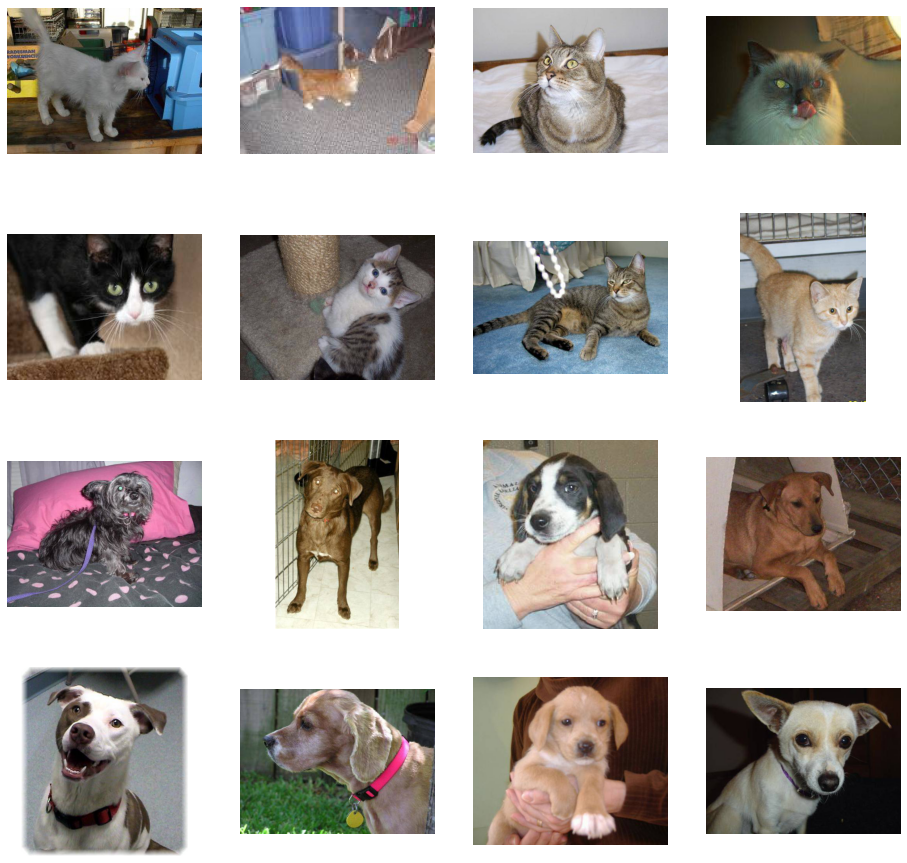

In [ ]:
# We can take a look at some of the images

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Generate the images 

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [ ]:
# baseline model for the dogs vs cats dataset
import sys
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD

In [ ]:
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [ ]:
# define model
model = define_model()

In [ ]:
# create data generator
datagen = ImageDataGenerator(rescale=1.0/255.0)

In [ ]:
# prepare iterators
train_it = datagen.flow_from_directory(train_dir,class_mode='binary', batch_size=64, target_size=(200, 200))
test_it = datagen.flow_from_directory(validation_dir,class_mode='binary', batch_size=64, target_size=(200, 200))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
# fit model
history = model.fit_generator(train_it, steps_per_epoch=len(train_it),validation_data=test_it, validation_steps=len(test_it), epochs=20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
32/32 [==============================] - 22s 322ms/step - loss: 0.6834 - accuracy: 0.5535 - val_loss: 0.7136 - val_accuracy: 0.5250
Epoch 2/20
32/32 [==============================] - 10s 303ms/step - loss: 0.6984 - accuracy: 0.5590 - val_loss: 0.6449 - val_accuracy: 0.6370
Epoch 3/20
32/32 [==============================] - 10s 307ms/step - loss: 0.6233 - accuracy: 0.6605 - val_loss: 0.6256 - val_accuracy: 0.6530
Epoch 4/20
32/32 [==============================] - 10s 308ms/step - loss: 0.5976 - accuracy: 0.6925 - val_loss: 0.6145 - val_accuracy: 0.6640
Epoch 5/20
32/32 [==============================] - 10s 306ms/step - loss: 0.5698 - accuracy: 0.7120 - val_loss: 0.6005 - val_accuracy: 0.6790
Epoch 6/20
32/32 [==============================] - 10s 327ms/step - loss: 0.5654 - accuracy: 0.7090 - val_loss: 0.6123 - val_accuracy: 0.6550
Epoch 7/20
32/32 [==============================] - 10s 303ms/step - loss: 0.5516 - accuracy: 0.7285 - val_loss: 0.6099 - val_accuracy: 0.6730

In [ ]:
# evaluate model
_, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
print('> %.3f' % (acc * 100.0))

> 70.300


In [ ]:
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')

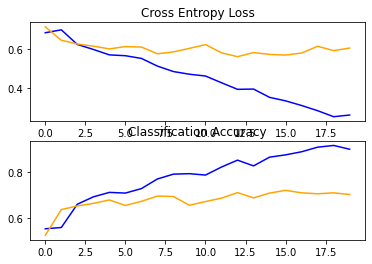

In [ ]:
summarize_diagnostics(history)

In [ ]:
# let's have a look at the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 128)      0

Develop Model Improvements From reviewing the learning curves for the model during training, the model showed strong signs of overfitting. We can explore two approaches to attempt to address this overfitting: dropout regularization and data augmentation. Both of these approaches are expected to slow the rate of improvement during training and hopefully counter the overfitting of the training dataset. As such, we will increase the number of training epochs from 20 to 50 to give the model more space for refinement.

In [ ]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.5))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [ ]:
# define model
model = define_model()

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255.0)

In [ ]:
# prepare iterators
train_it = datagen.flow_from_directory(train_dir,class_mode='binary', batch_size=64, target_size=(200, 200))
test_it = datagen.flow_from_directory(validation_dir,class_mode='binary', batch_size=64, target_size=(200, 200))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
# fit model
history = model.fit_generator(train_it, steps_per_epoch=len(train_it),validation_data=test_it, validation_steps=len(test_it), epochs=50)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
32/32 [==============================] - 10s 306ms/step - loss: 1.1449 - accuracy: 0.4955 - val_loss: 0.6931 - val_accuracy: 0.4990
Epoch 2/50
32/32 [==============================] - 10s 301ms/step - loss: 0.6936 - accuracy: 0.4835 - val_loss: 0.6931 - val_accuracy: 0.5280
Epoch 3/50
32/32 [==============================] - 10s 299ms/step - loss: 0.6932 - accuracy: 0.4865 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/50
32/32 [==============================] - 10s 312ms/step - loss: 0.6931 - accuracy: 0.5255 - val_loss: 0.6931 - val_accuracy: 0.5070
Epoch 5/50
32/32 [==============================] - 10s 314ms/step - loss: 0.6931 - accuracy: 0.4990 - val_loss: 0.6931 - val_accuracy: 0.5150
Epoch 6/50
32/32 [==============================] - 10s 300ms/step - loss: 0.6930 - accuracy: 0.5070 - val_loss: 0.6930 - val_accuracy: 0.5480
Epoch 7/50
32/32 [==============================] - 10s 299ms/step - loss: 0.6926 - accuracy: 0.5180 - val_loss: 0.6929 - val_accuracy: 0.5410

In [ ]:
# evaluate model
_, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
print('> %.3f' % (acc * 100.0))

> 54.400


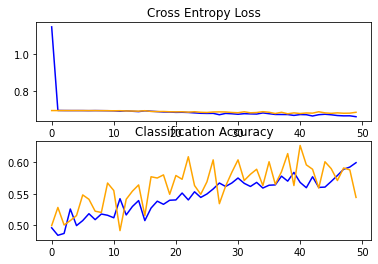

In [ ]:
summarize_diagnostics(history)

In [ ]:

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model
 
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()
 
# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generators
	train_datagen = ImageDataGenerator(rescale=1.0/255.0, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
	test_datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = train_datagen.flow_from_directory(train_dir,	class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = test_datagen.flow_from_directory(validation_dir,class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=0)
	# evaluate model
	_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)
 
# entry point, run the test harness
run_test_harness()

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.


> 73.200


In [ ]:
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')

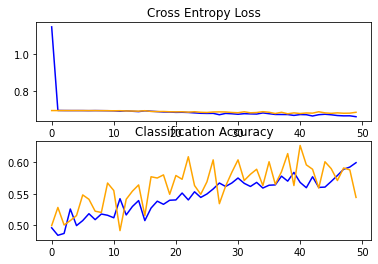

In [ ]:
summarize_diagnostics(history)